### Install Libraries


In [ ]:
!pip install pyshark
!pip install nest-asyncio
!pip install tornado
!pip install ip2geotools

In [ ]:
!dpkg --configure -a

In [ ]:
!apt-get install tshark --force-yes

### Import Libraries

In [ ]:
import pyshark
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import sys
import shutil
import os
from ip2geotools.databases.noncommercial import DbIpCity
import folium
from multiprocessing import Process, Manager
from os import system as cmd
import time


### 0. Extract 1 million of packets from the available data

In [ ]:
file_name = '../input/nbd-project/data.pcap'
new_file_name = './data_1m.pcap'

In [ ]:
cmd('editcap -r ' + file_name +" "+ new_file_name+ ' '+ " 0-1000000")

0

### 1. Extract general info from your trace using capinfos

In [ ]:
# Number of Packets in capture file
! capinfos -c './data_1m.pcap'

File name:           ./data_1m.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Number of packets:   1000 k


In [ ]:
# The average data rate, in bits/sec
! capinfos -i './data_1m.pcap'

File name:           ./data_1m.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Data bit rate:       2419 Mbps


In [ ]:
# The Average Packet Size
! capinfos -z './data_1m.pcap'

File name:           ./data_1m.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Average packet size: 1099.84 bytes


In [ ]:
# Generate all infos
! capinfos -A './data_1m.pcap'

File name:           ./data_1m.pcap
File type:           Wireshark/... - pcapng
File encapsulation:  Ethernet
File timestamp precision:  microseconds (6)
Packet size limit:   file hdr: (not set)
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Number of packets:   1000 k
File size:           98 MB
Data size:           1099 MB
Capture duration:    3.637099 seconds
First packet time:   2019-04-10 05:00:00.056001
Last packet time:    2019-04-10 05:00:03.693100
Data byte rate:      302 MBps
Data bit rate:       2419 Mbps
Average packet size: 1099.84 bytes
Average packet rate: 274 kpackets/s
SHA256:              0cd5fd34ddec92a3ea2072d102cc125c6a91bccc9f99e782dc9474f042f9b176
RIPEMD160:           b60314ed2d84263202ef3012d196be7820c0cea7
SHA1:                16bb7fe63a5a4a37e1d9b0cab842ab9af17655ac
Strict time order:   False
Capture application: Editcap (Wireshark) 3.4.2 (Git v3.4.2 packaged as 3.4.2-1~ubuntu16.04.0+wiresharkdevstable1)
Number of interfaces in file: 1
Interface #0 

### 2. Time Evaluation between Sequestial and Parallel reading

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
def extract_Info_pckt(file_name, sequence =True):  # lista_packet_ICMP

    pcap = pyshark.FileCapture(file_name)

    title = ["Label DSCP", "header len", "ds_field", "ds_field_ecn", "length",
             "Protocol", "flag_df", "flag_mf", "flag_rb", "fragment_offset", "ttl",
             "IP_SRC", "IP_DST", "src_port", "dst_port", "time"]

    total_info = []

    i = 0
    dscp = []
    total_info.append(title)

    for packet in pcap:

        values = []

        # We extract onòy the packets from IP Level and only Version IPv4
        # if 'IP' in packet and packet.eth.src == sorgente:
        if 'IP' in packet:

            # Label
            values.append(packet.ip.dsfield_dscp)
            dscp.append(packet.ip.dsfield_dscp)
            # Features

            # Header Length
            values.append(int(packet.ip.hdr_len))
            # Differentiated Service
            values.append(int(packet.ip.dsfield, 16))
            # Explicit Congestion Notification
            values.append(packet.ip.dsfield_ecn)
            # Length of the Packet including the header
            values.append(int(packet.ip.len))
            # Number of Protocol (e.g. 6 = TCP, 17 = UDP, 1 = ICMP)
            values.append(int(packet.ip.proto))
            # Flag Do not Fragment
            values.append(packet.ip.flags_df)
            # Flag More Fragment
            values.append(packet.ip.flags_mf)
            # Flag Reserved - Must be 0
            values.append(packet.ip.flags_rb)
            # Fragment Offset
            values.append(packet.ip.frag_offset)
            # Time To Live
            values.append(int(packet.ip.ttl))

            #### Extraction of the Ip Source and Ip Destination###

            source = packet.ip.src
            values.append(source)

            destination = packet.ip.dst
            values.append(destination)

            #### Extraction of the Port ####
            if "UDP" in packet:
                values.append(packet.udp.srcport)
                values.append(packet.udp.dstport)

            elif "TCP" in packet:
                values.append(packet.tcp.srcport)
                values.append(packet.tcp.dstport)

            else:
                # Protocol as IP and ICMP e Ws.Short Port in src and dst will be set to -1
                values.append(-1)
                values.append(-1)

            # if "ICMP" in packet:
            #    lista_packet_ICMP.append((packet.ip.dsfield_dscp, packet.icmp.type, packet.icmp.code))

            # Time will be used for the simulation
            time = float(packet.sniff_timestamp)
            values.append(time)

            # Update the number of pckts
            i += 1

            # Store all the caracteristics of a packet into the Totale list
            total_info.append(values)

    pcap.close()

    # Creation of the data frame
    dataFrame = pd.DataFrame(total_info[1:], columns=total_info[0])
    
    # Parallel
    if sequence == False:
        dataFrame.to_csv(file_name + '_PacketDataFrame.csv')

    return dataFrame

**Reading Sequential**

In [ ]:
def read_sequence():
    # Sequence
    file_name = './data_1m.pcap'
    output_sequence_file = './data_sequence.csv'

    start_time = time.time()
    print('Reading Sequential')
    print('Start time: ', start_time)
    dataFrame = extract_Info_pckt(file_name, True)
    print("Finish to read al pcap file")
    end_time = time.time()
    print('End time: ', end_time)
    print("--- %s seconds ---" % (end_time - start_time))
    dataFrame.to_csv(output_sequence_file)

In [ ]:
read_sequence()

Reading Sequential
Start time:  1625587092.7318761
Finish to read al pcap file
End time:  1625589042.2021682
--- 1949.4702920913696 seconds ---


**Reading Parallel**

In [ ]:
def read_parallel():
    print('Reading Parallel')
    # Parallel
    file_name = './data_1m.pcap'
    sub_dir = './SplitRead/'
    # Remove directory already created
    shutil.rmtree('./SplitRead/')

    try:
        os.mkdir(sub_dir)
    except OSError:
        print("Creation of the directory %s failed" % sub_dir)
    else:
        print("Successfully created the directory %s" % sub_dir)

    cmd('editcap -c 1000 ' + file_name + " " + sub_dir + "__mini.pcap")

    splitting_file = sorted(glob.glob(sub_dir + "*.pcap"))

    manager = Manager()

    start_time = time.time()
    print('Start time: ', start_time)

    lista_process = []

    for i in range(len(splitting_file)):
        file = splitting_file[i]
        p1 = Process(target=extract_Info_pckt, args=(file,False))

        lista_process.append(p1)

        p1.start()

    for process in lista_process:
        process.join()

    ### Finish ####
    print("Finish to read al pcap file")
    end_time = time.time()
    print('End time: ', end_time)
    print("--- %s seconds ---" % (end_time - start_time))

In [ ]:
read_parallel()

Reading Parallel
Successfully created the directory ./SplitRead/
Start time:  1625654081.9045105
Finish to read al pcap file
End time:  1625655261.8491263
--- 1179.9446158409119 seconds ---


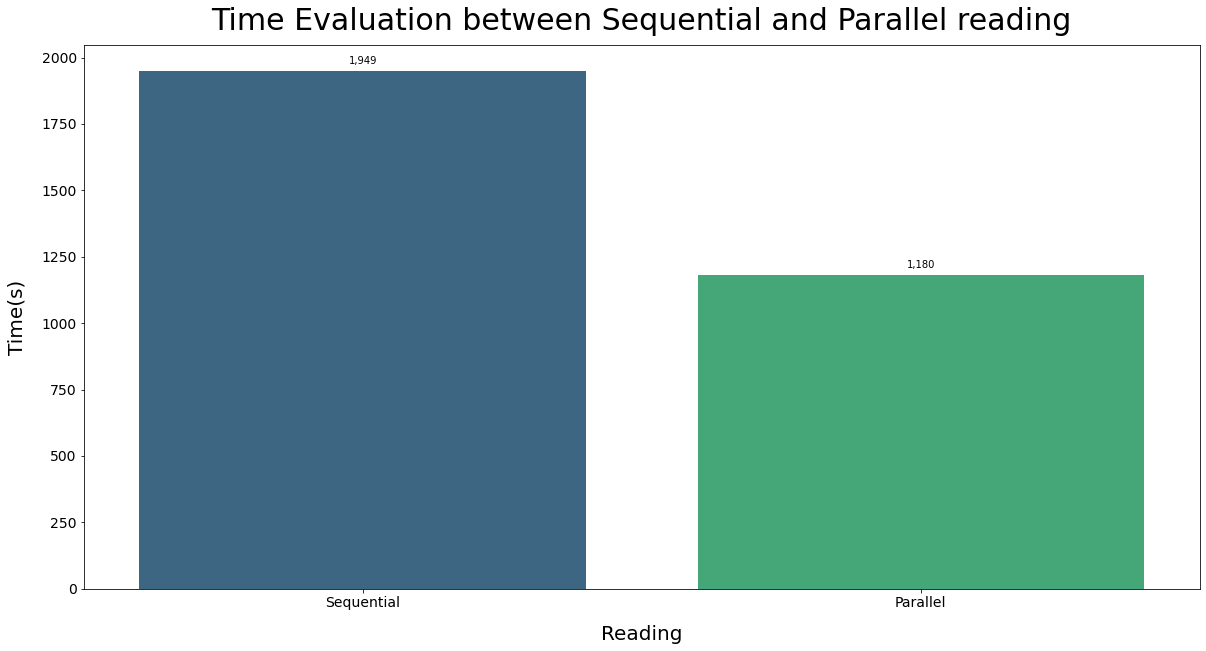

In [ ]:
time_df = pd.DataFrame({'Reading': ['Sequential', 'Parallel'], 'Time': [1949, 1180]}, 
                  columns=['Reading', 'Time'])

plt.figure(figsize=(20,10))
plot = sns.barplot(x='Reading',y='Time',data=time_df, palette  = sns.color_palette('viridis', 2))
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Time Evaluation between Sequential and Parallel reading', fontsize = 30, loc = 'center', pad = 15)
plt.xlabel('Reading', fontsize = 20, labelpad = 15)
plt.ylabel('Time(s)', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
dataFrame = pd.read_csv('./data_sequence.csv')

In [ ]:
dataFrame.head()

,Unnamed: 0,Label DSCP,header len,ds_field,ds_field_ecn,length,Protocol,flag_df,flag_mf,flag_rb,fragment_offset,ttl,IP_SRC,IP_DST,src_port,dst_port,time
0,0,0,20,0,0,95,17,1,0,0,0,57,23.53.35.140,131.137.126.25,53,48350,1.554872e+09
1,1,0,20,0,0,1420,6,1,0,0,0,56,150.57.136.251,221.244.225.179,80,64918,1.554872e+09
2,2,0,20,0,0,52,6,0,0,0,0,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09
3,3,0,20,0,0,52,6,0,0,0,0,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09
4,4,0,20,0,0,141,17,0,0,0,0,58,150.57.190.76,155.70.48.196,50821,27023,1.554872e+09


### 3. Extract the IP which generates the highest amount of sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint


In [ ]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum').reset_index().sort_values('length', ascending = False).head(5)
print(data_couple)


               IP_SRC     length
1457   150.57.136.251  646286708
3484  203.122.131.143   49658173
3392    202.7.174.242   39305437
1752    150.57.242.48   32295298
3520   203.122.136.47   18161035


As we can see, Source IP **150.57.136.251** has the highest amount of sender traffic

In [ ]:
def bitRate(data, step_sec = 0.1):
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    # print("Start: ",start)
    # print("Finish: ",finish)
    
    
    data["time"] -= data.iloc[0]["time"]
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    
    # print("Start: ",start)
    # print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    # print(step)
    for i in range(int(step)):
    
        #From Byte to bit
        val = np.sum(data[(data["time"]>=start) & (data["time"]<finish)]["length"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec
        
    return value


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 

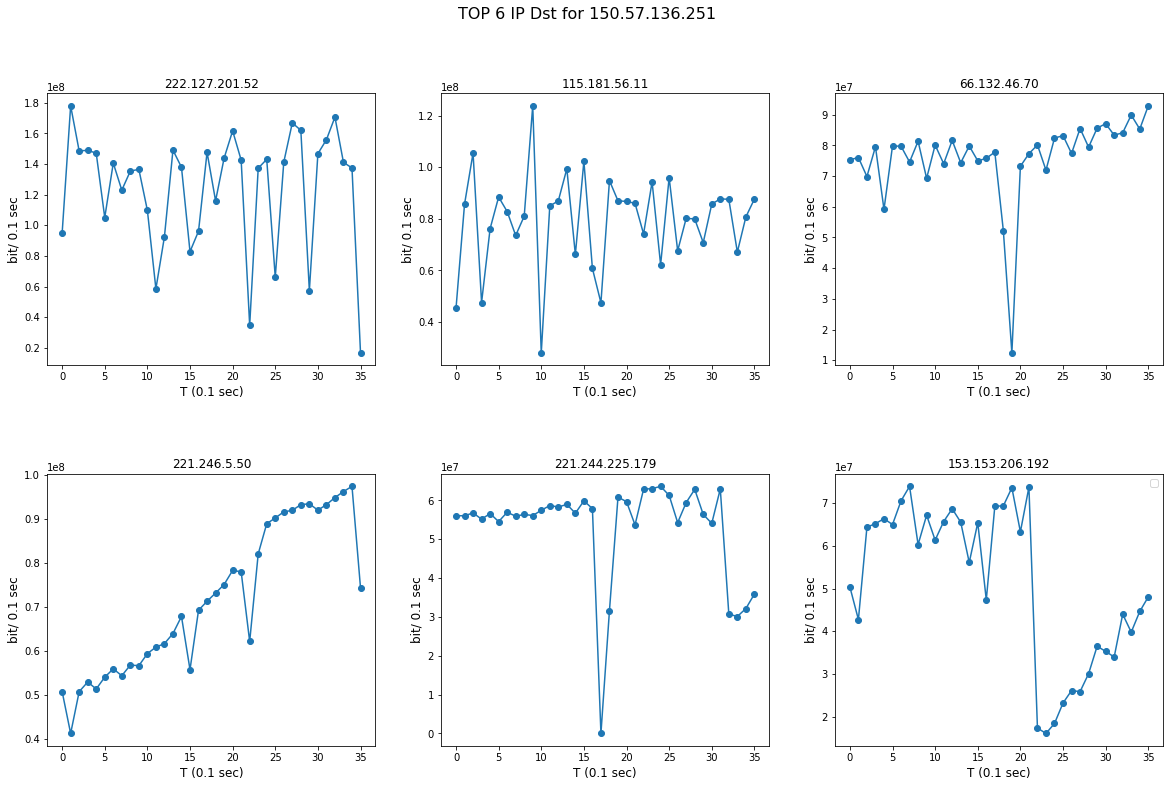

In [ ]:
personal_IP = '150.57.136.251'

onlyMyIP = dataFrame[dataFrame["IP_SRC"] == personal_IP]
grouped = onlyMyIP.groupby(["IP_DST"]).agg('sum').sort_values(by=['length'], ascending=False).head(6)
data_couple = onlyMyIP.groupby(["IP_DST"])


rowlength = int(grouped.shape[0]/2)   # fix up if odd number of groups
fig, axs = plt.subplots(figsize=(20,12), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 
fig.tight_layout()
targets = zip(grouped.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
    # print(key)
    ax.plot(bitRate(data_couple.get_group(key)),marker = "o")
    ax.set_title(key)
    ax.set_xlabel("T (0.1 sec)",  fontsize=12)
    ax.set_ylabel("bit/ 0.1 sec",  fontsize=12)
ax.legend()
fig.suptitle('TOP 6 IP Dst for '+  personal_IP , fontsize=16)
plt.show()


### 4. Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)

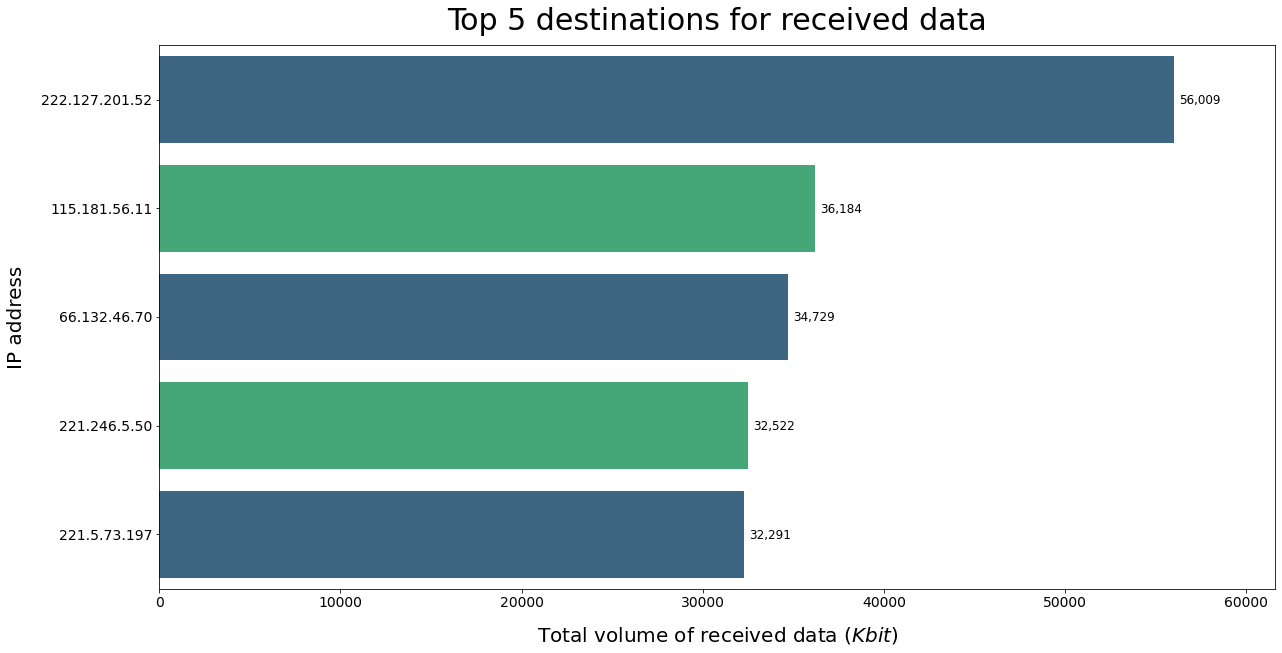

In [ ]:
data_couple = dataFrame.groupby(["IP_DST"])[['length']].agg('sum').reset_index().sort_values(by=['length'], ascending=False).head(5)

data_couple['length']= data_couple.apply(lambda x: x['length']/1e3,axis=1)

plt.figure(figsize = (20, 10))

plot = sns.barplot(x='length',y='IP_DST',data=data_couple, palette  = sns.color_palette('viridis', 2))

for p in plot.patches:
    plot.annotate(format(p.get_width(), ',.0f'),
                (p.get_x() + p.get_width(), p.get_y() + 0.5),
                va = 'center', 
                fontsize = 12,
                xytext=(5, 10), textcoords='offset points')


plt.title('Top 5 destinations for received data', fontsize = 30, loc = 'center', pad = 15)
plt.ylabel('IP address', fontsize = 20, labelpad = 15)
plt.xlabel('Total volume of received data ($Kbit$)', fontsize = 20, labelpad = 15)
plt.xlim(0,data_couple['length'].max()*1.1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

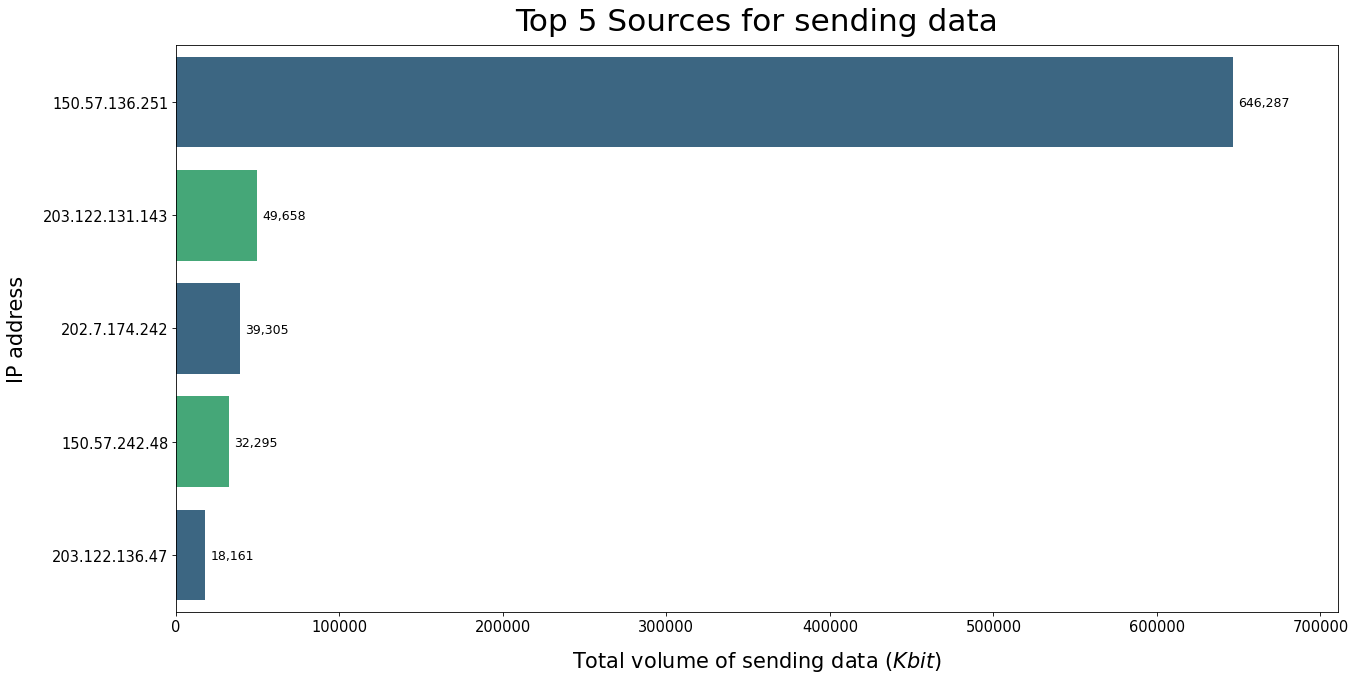

In [ ]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum').reset_index().sort_values(by=['length'], ascending=False).head(5)

data_couple['length']= data_couple.apply(lambda x: x['length']/1e3,axis=1)

plt.figure(figsize = (20, 10), dpi = 75)

plot = sns.barplot(x='length',y='IP_SRC',data=data_couple, palette  = sns.color_palette('viridis', 2))

for p in plot.patches:
    plot.annotate(format(p.get_width(), ',.0f'),
                (p.get_x() + p.get_width(), p.get_y() + 0.5),
                va = 'center', 
                fontsize = 12,
                xytext=(5, 10), textcoords='offset points')

plt.title('Top 5 Sources for sending data', fontsize = 30, loc = 'center', pad = 15)
plt.ylabel('IP address', fontsize = 20, labelpad = 15)
plt.xlabel('Total volume of sending data ($Kbit$)', fontsize = 20, labelpad = 15)
plt.xlim(0,data_couple['length'].max()*1.1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

### 5. Evaluate bitRate considering all the trace with 3 different sampling rate

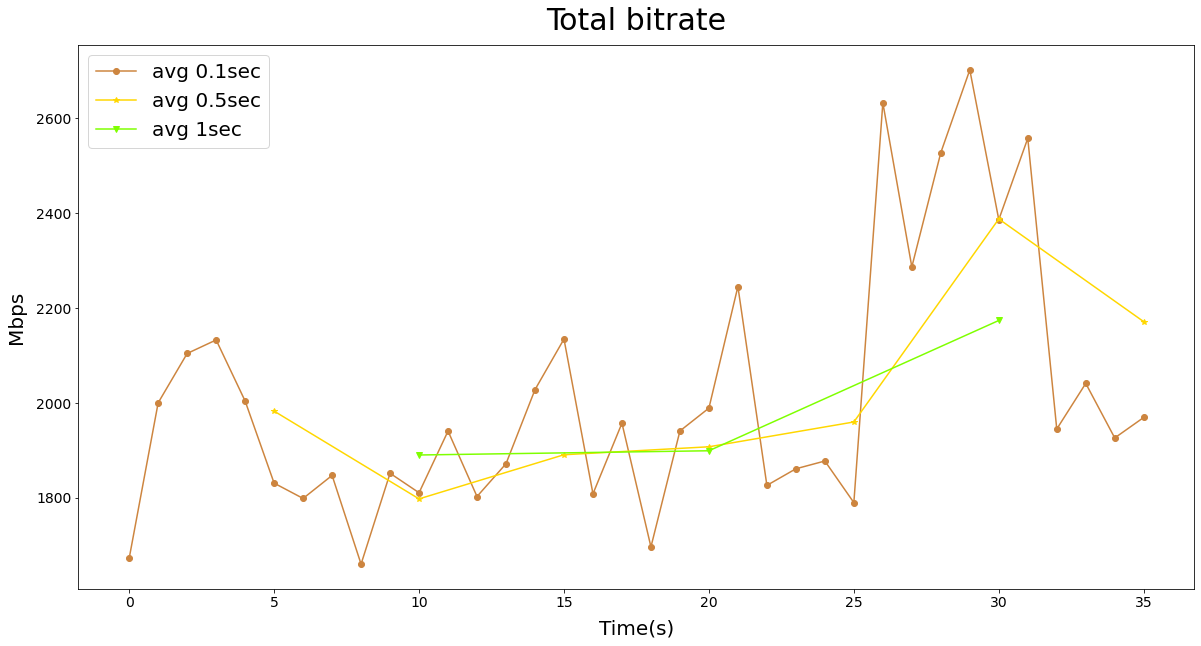

In [ ]:
plt.figure(figsize = (20, 10))

plt.plot(list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))), color = 'peru',marker="o",label = "avg 0.1sec")
plt.plot([ i*5 for i in range(1,len(list(map(lambda x: x/1e6, 
                                             bitRate(dataFrame,0.5))))+1)],list(map(lambda x: x/1e6, bitRate(dataFrame,0.5))), color = 'gold',marker="*",label = "avg 0.5sec")
plt.plot([ i*10 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,1))))+1)],list(map(lambda x: x/1e6, bitRate(dataFrame,1))), 
         color = 'chartreuse',marker="v",label = "avg 1sec")

#plt.plot(list(map(lambda x: x/1e6, bitRate(dataFrame,10))), color = 'olivedrab',marker="o-")
plt.xlabel('Time(s)', fontsize = 20, labelpad = 10)
plt.ylabel('Mbps', fontsize = 20, labelpad = 10)
plt.title('Total bitrate', fontsize = 30, pad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize=20,loc="best")
# plt.savefig(folder_image +"BitRate different Averages")
plt.show()

### 6. GeoLocal Referenciation of the 5 sessions with highest amount of traffic generated

In [ ]:
def geo_infos(ip_src_list, ip_dst_list):

  src_geo_info = []
  dst_geo_info = []
  i = 0

  for j in range(len(ip_src_list)):
    try:
      src_response = DbIpCity.get(ip_src_list[j], api_key='free')
      dst_response = DbIpCity.get(ip_dst_list[j], api_key='free')
    except:
      continue
    if src_response.latitude == None or dst_response.latitude == None: 
      continue
    i +=1
    src_geo_info.append([src_response.latitude, src_response.longitude, src_response.region])
    dst_geo_info.append([dst_response.latitude, dst_response.longitude, dst_response.region])
    if i == 10: break

  return src_geo_info, dst_geo_info

In [ ]:
data_couple = copy.deepcopy(dataFrame)
#% 5 sessions with the highest amount of traffic generated 
data_couple = data_couple.groupby(["IP_SRC","IP_DST"])[['length']].agg('sum').reset_index().sort_values('length', ascending = False).head(5)
# have changed
list_src = data_couple['IP_SRC'].tolist()
list_dst = data_couple['IP_DST'].tolist()

#5 Couples
src_geo, dst_geo = geo_infos(list_src, list_dst)

src_geo = pd.DataFrame(src_geo, columns=['latitude', 'longitude', 'region'])
dst_geo = pd.DataFrame(dst_geo, columns=['latitude', 'longitude', 'region'])

flow_map = folium.Map([0, 0], zoom_start=2, tiles='Stamen Terrain')

for i in range(len(src_geo)):
    folium.Marker([dst_geo.loc[i][0], dst_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>',  
                icon=folium.Icon(color='red')).add_to(flow_map)
    folium.Marker([src_geo.loc[i][0], src_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>', 
                icon=folium.Icon(color='green')).add_to(flow_map)
    folium.PolyLine([(src_geo.loc[i][0], src_geo.loc[i][1]), (dst_geo.loc[i][0], dst_geo.loc[i][1])], 
                  color="blue", weight=1.5, opacity=1).add_to(flow_map)
display(flow_map)


**Note:** i-green is a IP source and i-red is a IP destination 

### 7. 10 Protocol mostly used

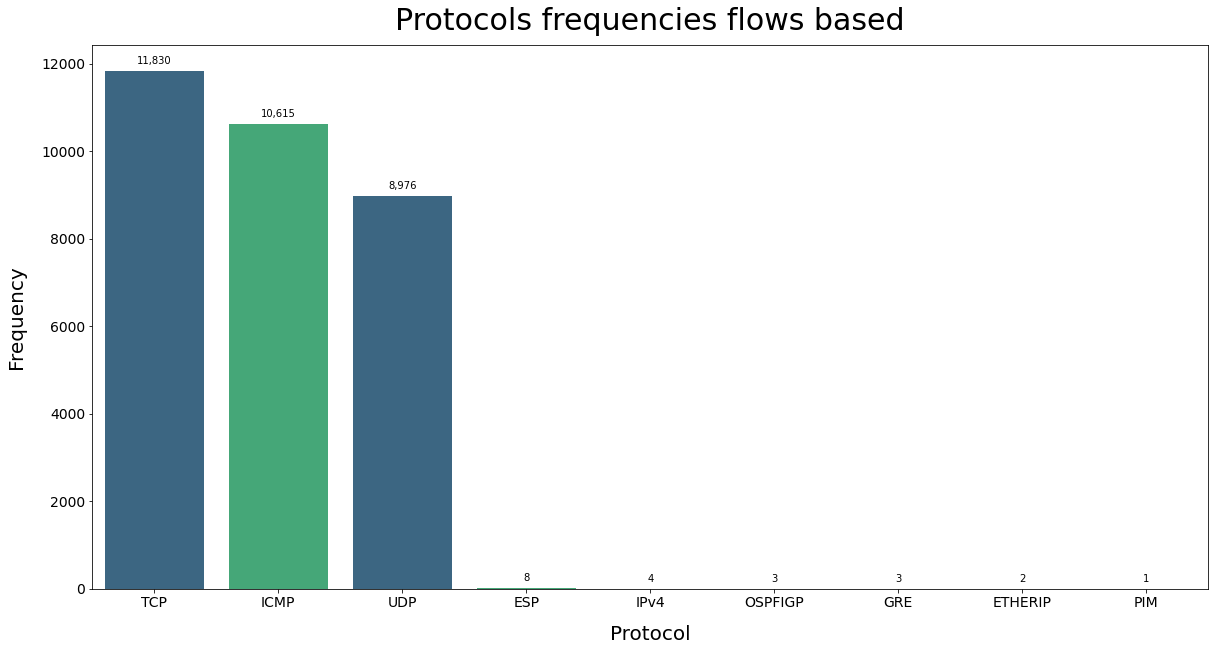

In [ ]:
grouped_flows = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()

grouped_flows["Protocol"] = grouped_flows["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP", 50: "ESP", 4: "IPv4", 47:"GRE", 89: "OSPFIGP", 97: "ETHERIP", 103: "PIM"})
grouped_flows = grouped_flows.astype({"Protocol": str})

df = grouped_flows.Protocol.value_counts().rename_axis('Protocols').reset_index(name='counts')

plt.figure(figsize=(20,10))
plot = sns.barplot(x='Protocols',y='counts',data=df, palette  = sns.color_palette('viridis', 2))
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Protocols frequencies flows based', fontsize = 30, loc = 'center', pad = 15)
plt.xlabel('Protocol', fontsize = 20, labelpad = 15)
plt.ylabel('Frequency', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

### 8. Port Scanner evaluation (10 Ports mostly used)

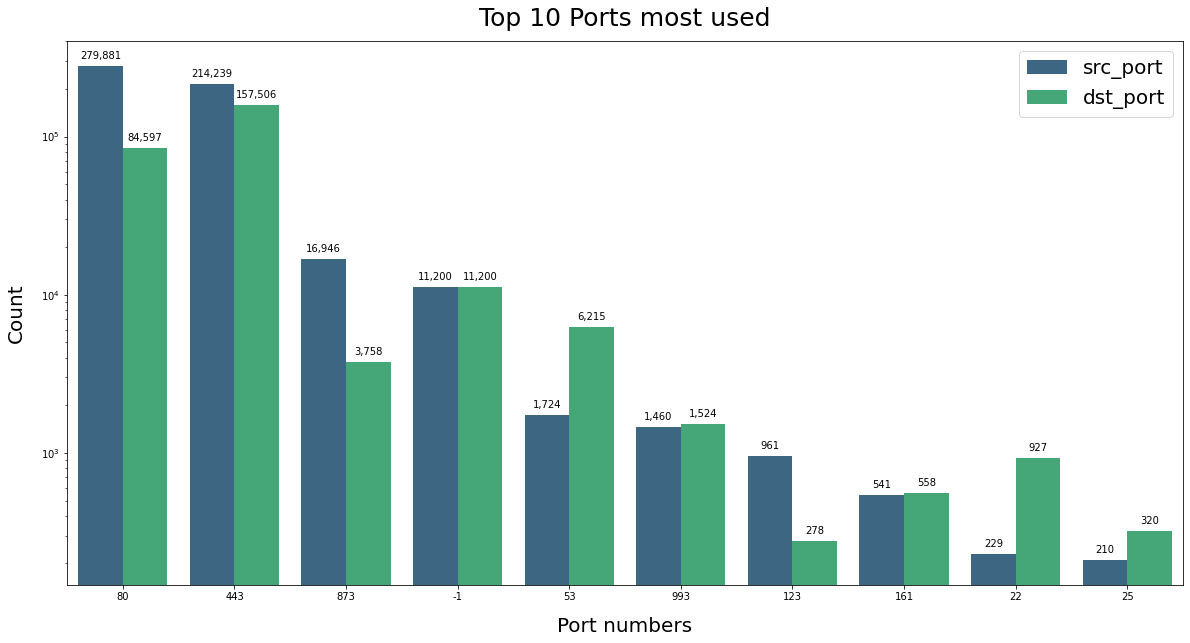

In [ ]:
dataFrame = dataFrame.astype({"src_port": int, "dst_port": int})
# have changed
src_counts = dataFrame[dataFrame.src_port < 1024].src_port.value_counts().rename_axis('port').reset_index(name='src_port').head(10)

dst_counts = dataFrame[dataFrame.dst_port < 1024].dst_port.value_counts().rename_axis('port').reset_index(name='dst_port').head(10)

result = pd.merge(src_counts, dst_counts, on="port").sort_values(by=['src_port'], ascending = False)

fig, ax1 = plt.subplots(figsize=(20, 10))
tidy = pd.melt(result, id_vars='port', var_name="source", value_name="value_numbers")
plot = sns.barplot(x='port', y="value_numbers", hue="source", data=tidy, ax=ax1, palette  = sns.color_palette('viridis', 2), order= result.sort_values('src_port', ascending = False).port)

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.legend(fontsize=20)
plt.yscale('log')
plt.title('Top 10 Ports most used', fontsize = 25, pad = 15)
plt.xlabel('Port numbers', fontsize = 20, labelpad = 15)
plt.ylabel('Count', fontsize = 20, labelpad = 15)
plt.show()

### 9. InterArrival Time boxplot between TCP and UDP Sessions

In [ ]:
data_protocol = copy.deepcopy(dataFrame[dataFrame["Protocol"].isin([6,17])])
data_protocol["Protocol"] = data_protocol["Protocol"].replace({6:"TCP",17:"UDP"})

In [ ]:
# InterArrival Time calculation
data_protocol = data_protocol.assign(InterArrivalTime = data_protocol.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port'], group_keys=False).apply(lambda x: x.time.diff()).fillna(0))
data_protocol

,Unnamed: 0,Label DSCP,header len,ds_field,ds_field_ecn,length,Protocol,flag_df,flag_mf,flag_rb,fragment_offset,ttl,IP_SRC,IP_DST,src_port,dst_port,time,InterArrivalTime
0,0,0,20,0,0,95,UDP,1,0,0,0,57,23.53.35.140,131.137.126.25,53,48350,0.000000,0.000000
1,1,0,20,0,0,1420,TCP,1,0,0,0,56,150.57.136.251,221.244.225.179,80,64918,0.000017,0.000000
2,2,0,20,0,0,52,TCP,0,0,0,0,54,180.213.208.201,203.122.136.47,53480,80,0.000028,0.000000
3,3,0,20,0,0,52,TCP,0,0,0,0,54,180.213.208.201,203.122.136.47,53480,80,0.000033,0.000005
4,4,0,20,0,0,141,UDP,0,0,0,0,58,150.57.190.76,155.70.48.196,50821,27023,0.000043,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832763,832763,0,20,0,0,1454,TCP,1,0,0,0,56,150.57.136.251,222.127.201.52,80,62620,3.637075,0.000049
832764,832764,0,20,0,0,1500,TCP,1,0,0,0,60,150.57.136.251,66.132.46.70,873,8878,3.637079,0.003948
832765,832765,0,20,0,0,1500,TCP,1,0,0,0,60,150.57.136.251,66.132.46.70,873,8878,3.637095,0.000016
832766,832766,0,20,0,0,1500,TCP,1,0,0,0,60,150.57.136.251,66.132.46.70,873,8878,3.637097,0.000002


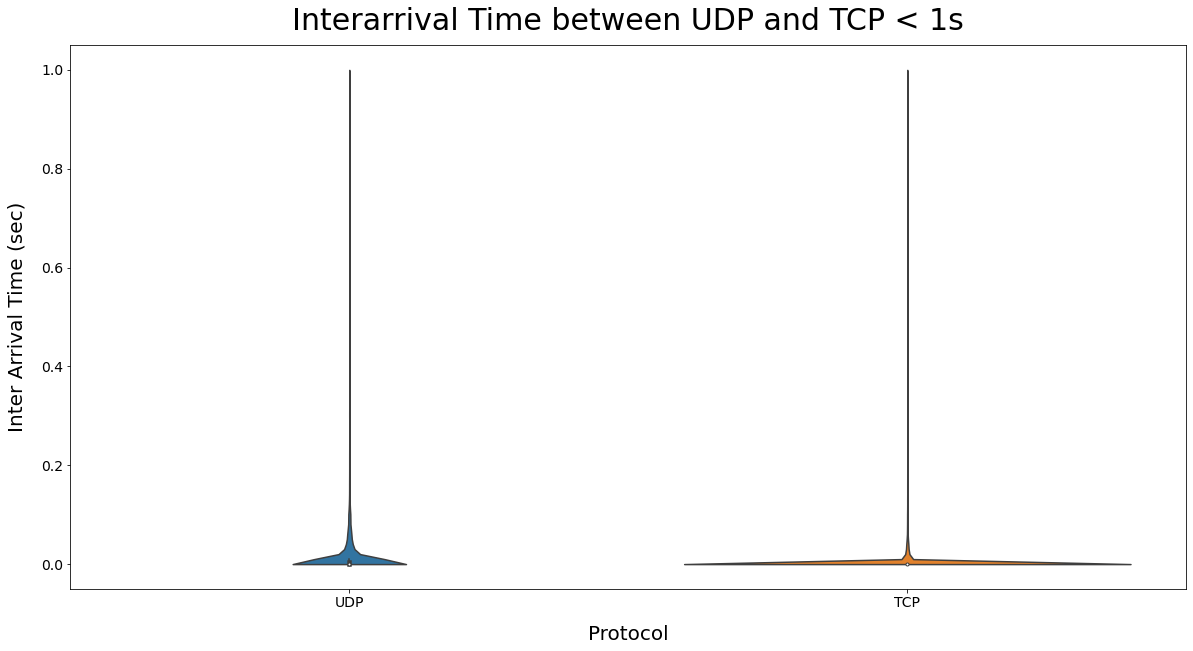

In [ ]:
#Time under 1 sec
plt.figure(figsize = (20, 10))
df_ = data_protocol[data_protocol["InterArrivalTime"] < 1]
ax = sns.violinplot(x="Protocol", y="InterArrivalTime", data=df_, cut=0)
plt.title('Interarrival Time between UDP and TCP < 1s', fontsize = 30, loc = 'center', pad = 15)
plt.xlabel('Protocol', fontsize = 20, labelpad = 15)
plt.ylabel('Inter Arrival Time (sec)', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

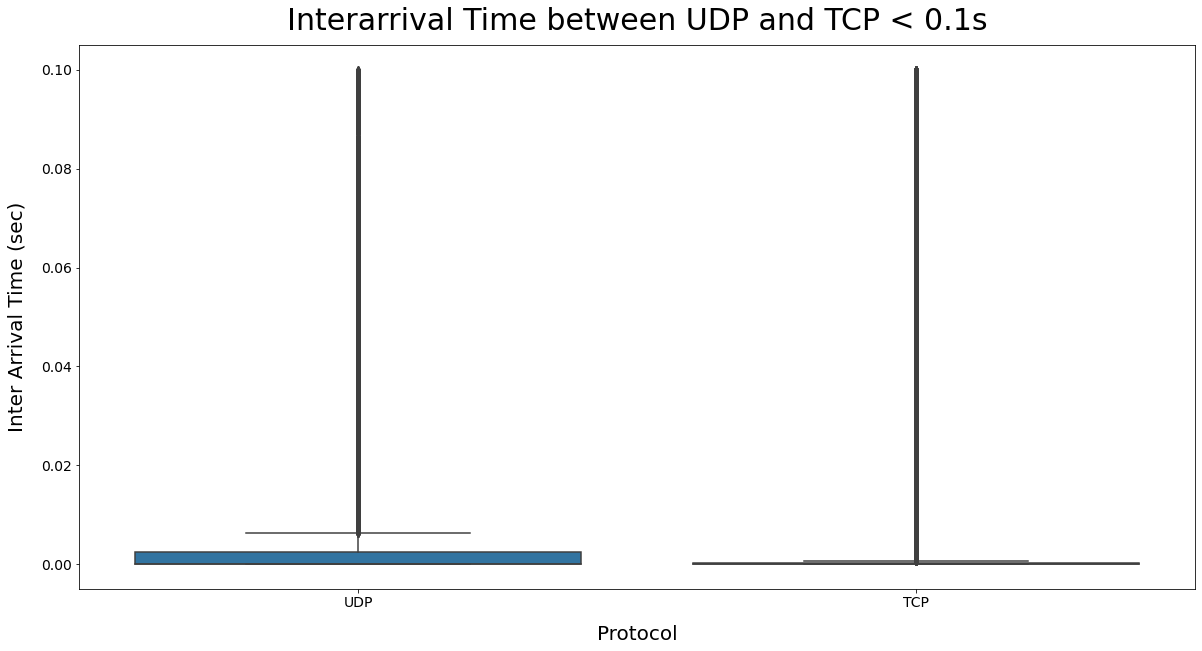

In [ ]:
#Time under 0.1 sec
plt.figure(figsize = (20, 10))
df_ = data_protocol[data_protocol["InterArrivalTime"] < 0.1]
ax = sns.boxplot(x="Protocol", y="InterArrivalTime", data=df_)

plt.title('Interarrival Time between UDP and TCP < 0.1s', fontsize = 30, loc = 'center', pad = 15)
plt.xlabel('Protocol', fontsize = 20, labelpad = 15)
plt.ylabel('Inter Arrival Time (sec)', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# Mean InterArrival Time between 2 sessions
data_protocol.groupby('Protocol').InterArrivalTime.agg('mean').reset_index(name='Mean InterArrival Time')

,Protocol,Mean InterArrival Time
0,TCP,0.007512
1,UDP,0.034231


### Bonus: Top 15 TTL most used

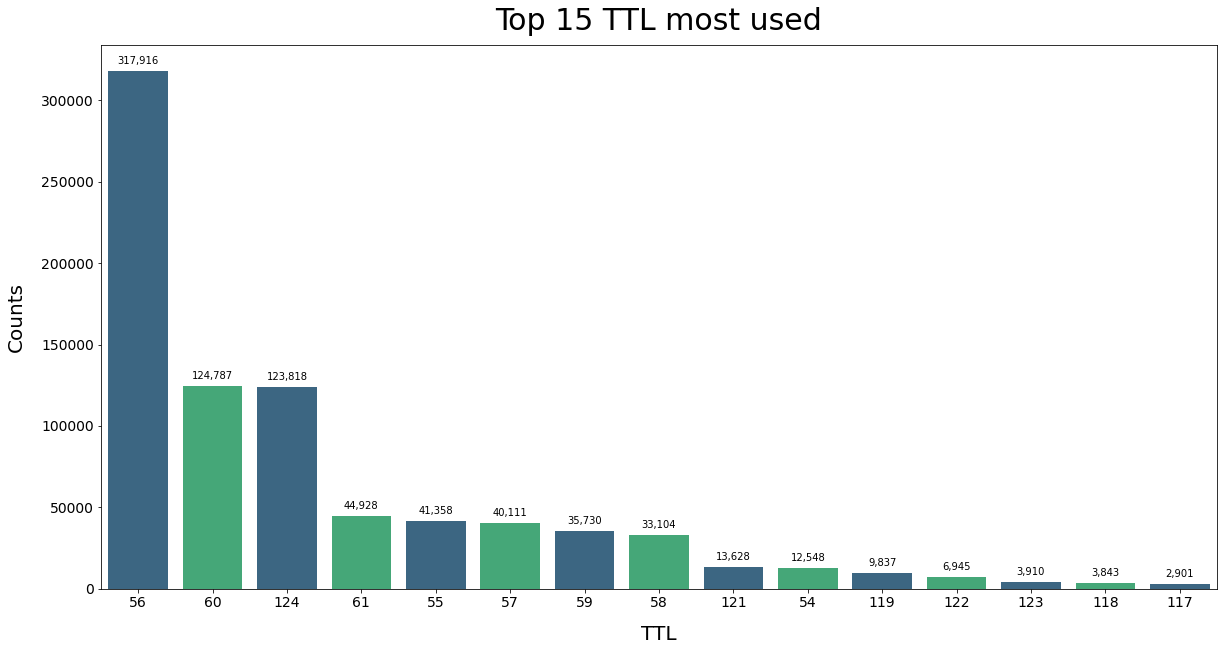

In [ ]:
df = dataFrame.ttl.value_counts().rename_axis('TTL').reset_index(name='counts').sort_values(by=['counts'], ascending = False).head(15)

plt.figure(figsize=(20,10))
plot = sns.barplot(x='TTL',y='counts',data=df, palette  = sns.color_palette('viridis', 2), order = df.sort_values(by=['counts'], ascending = False).TTL)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center',
                    va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

plt.title('Top 15 TTL most used', fontsize = 30, loc = 'center', pad = 15)
plt.xlabel('TTL', fontsize = 20, labelpad = 15)
plt.ylabel('Counts', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

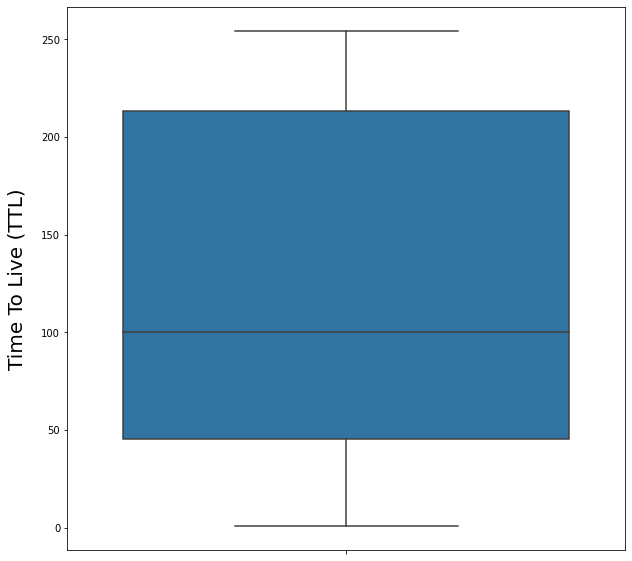

In [ ]:
df = dataFrame.ttl.value_counts().rename_axis('TTL').reset_index(name='counts')
plt.figure(figsize=(10,10))
ax = sns.boxplot(y=df["TTL"])
plt.ylabel('Time To Live (TTL)', fontsize = 20, labelpad = 15)
plt.show()

<Figure size 1440x720 with 0 Axes>

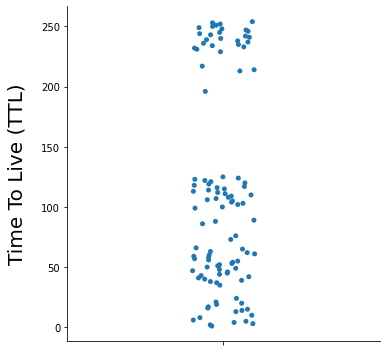

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.catplot(y="TTL", data=df)
plt.ylabel('Time To Live (TTL)', fontsize = 20, labelpad = 15)
plt.show()